# Part 1. Gender Classification from audio files

The goal of this part of the assignment is to perform a gender classification task. We will train different ML algorithms on OpenSLR's [LibriSpeech corpus](http://www.openslr.org/12/). LibriSpeech is a corpus of read speech, based on LibriVox's public domain
audio books. Its purpose is to enable the training and testing of automatic
speech recognition (ASR) systems. 

We will use the _dev-clean_ subset of the corpus, a development set containing "clean" speech, which consists of audio files of 40 speakers, labelled by gender.





In [1]:
# !pip install python_speech_features
# !pip install fairseq

## Imports

In [2]:
import datetime
import glob
import math
import os
import time

import fairseq
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import torch
from matplotlib.pyplot import figure
from python_speech_features import mfcc
from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from helpers import *

# Automatically reload modules
%load_ext autoreload
%autoreload 2

2023-02-13 04:04:26 | INFO | numexpr.utils | NumExpr defaulting to 4 threads.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# if os.path.isfile("/content/LibriSpeech.zip") == False:
#   ! cp '/content/drive/MyDrive/Voiseed/LibriSpeech.zip' '/content/LibriSpeech.zip'
#   ! unzip -q LibriSpeech.zip -d /content/
#   print(f"Successfully copied and unzipped LibriSpeech.zip to /content/ directory")
# else:
#   print(f"LibriSpeech.zip already exists in /content/ directory")


# if os.path.isfile("/content/models.zip") == False:
#   ! cp '/content/drive/MyDrive/Voiseed/models.zip' '/content/models.zip'
#   ! unzip -q models.zip -d /content/
#   print(f"Successfully copied and unzipped models.zip to /content/ directory")
# else:
#   print(f"models.zip already exists in /content/ directory")

## File paths and global variables

In [4]:
SPEAKERS_METADATA = "./LibriSpeech/SPEAKERS.TXT"
DEV_CLEAN = "./LibriSpeech/dev-clean/"

In [5]:
NUMCEP = 40  # number of cepstrum for MFCCs extraction (40 gave the best results)
SPLIT_RATIO = 0.5  # train set split ratio
sns.set_theme(style="darkgrid")

## Load data

### Get ids and genres from metadata

Get information about speakers' gender and total amount of audio in the whole corpus.

In [6]:
speakers_gender = {}

with open(SPEAKERS_METADATA) as f:
    for line in f:
        if ";" not in line:
            speaker_id = int(line.split("|")[0])
            gender = line.split("|")[1].strip()
            speakers_gender[speaker_id] = 0 if gender == 'M' else 1
            
print(f"Total number of speakers in whole corpus:  {len(speakers_gender):>5,}")

Total number of speakers in whole corpus:  2,484


### Get ids and genres for "dev-clean" subset

In [7]:
# get all speakers ids in dev-clean subset of the corpus folder
speaker_ids = [int(speaker_dir) for speaker_dir in os.listdir(DEV_CLEAN) if not speaker_dir.startswith('.') ]
male_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 0]
female_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 1]

print(f"Number of speakers in dev-clean's subset:  {len(speaker_ids):>5,}")
print(f"• Number of male speakers:                 {len(male_ids):>5,}")
print(f"• Number of female speakers:               {len(female_ids):>5,}")

Number of speakers in dev-clean's subset:     40
• Number of male speakers:                    20
• Number of female speakers:                  20


## Build dataset

### Split speaker ids for train and test sets

We make sure we train our model with a balanced training set by adding the same amount of males and females in the training set.

In [8]:
print(f"Split train / test sets ({SPLIT_RATIO:.0%}/{1-SPLIT_RATIO:.0%}) for male and female speakers: ")
male_ids_train, male_ids_test = split_speakers(male_ids, SPLIT_RATIO)
female_ids_train, female_ids_test = split_speakers(female_ids, SPLIT_RATIO)

print(f"• Number of male ids for train set:   {len(male_ids_train):>3}")
print(f"• Number of female ids for train set: {len(female_ids_train):>3}")
print(f"• Number of male ids for test set:    {len(male_ids_test):>3}")
print(f"• Number of female ids for test set:  {len(female_ids_test):>3}")

Split train / test sets (50%/50%) for male and female speakers: 
• Number of male ids for train set:    10
• Number of female ids for train set:  10
• Number of male ids for test set:     10
• Number of female ids for test set:   10


### Extract MFCC features from audio files

In [9]:
print("Build train dataset: ")
train_dataset = build_dataset(male_ids_train + female_ids_train, speakers_gender, NUMCEP, DEV_CLEAN)
print(train_dataset.shape, "\n")

print("Build test dataset: ")
test_dataset = build_dataset(male_ids_test + female_ids_test, speakers_gender, NUMCEP, DEV_CLEAN)
print(test_dataset.shape, "\n")

Build train dataset: 


Extracting MFCCs:   0%|          | 0/20 [00:00<?, ?it/s]

Speaker 3000:  47 audio files, gender 0 (M)
Speaker 8297:  75 audio files, gender 0 (M)
Speaker  174:  59 audio files, gender 0 (M)
Speaker  777:  82 audio files, gender 0 (M)
Speaker  422:  36 audio files, gender 0 (M)
Speaker 2428:  87 audio files, gender 0 (M)
Speaker  251:  75 audio files, gender 0 (M)
Speaker  652:  71 audio files, gender 0 (M)
Speaker 6295:  74 audio files, gender 0 (M)
Speaker 3752: 101 audio files, gender 0 (M)
Speaker 1993:  58 audio files, gender 1 (F)
Speaker   84:  65 audio files, gender 1 (F)
Speaker 7850:  72 audio files, gender 1 (F)
Speaker 3536:  64 audio files, gender 1 (F)
Speaker 1919:  64 audio files, gender 1 (F)
Speaker 5338:  59 audio files, gender 1 (F)
Speaker 6313:  96 audio files, gender 1 (F)
Speaker 3576:  41 audio files, gender 1 (F)
Speaker 1462:  94 audio files, gender 1 (F)
Speaker 1988:  75 audio files, gender 1 (F)
(1395, 41) 

Build test dataset: 


Extracting MFCCs:   0%|          | 0/20 [00:00<?, ?it/s]

Speaker 6241:  78 audio files, gender 0 (M)
Speaker 2078:  52 audio files, gender 0 (M)
Speaker 1272:  73 audio files, gender 0 (M)
Speaker 3170:  49 audio files, gender 0 (M)
Speaker 2803:  57 audio files, gender 0 (M)
Speaker 2902:  38 audio files, gender 0 (M)
Speaker 7976:  78 audio files, gender 0 (M)
Speaker 2086:  55 audio files, gender 0 (M)
Speaker 5694:  83 audio files, gender 0 (M)
Speaker 5536:  59 audio files, gender 0 (M)
Speaker 3853:  57 audio files, gender 1 (F)
Speaker 2412:  58 audio files, gender 1 (F)
Speaker 2035:  77 audio files, gender 1 (F)
Speaker 1673:  42 audio files, gender 1 (F)
Speaker 2277:  95 audio files, gender 1 (F)
Speaker 6319:  55 audio files, gender 1 (F)
Speaker 5895:  80 audio files, gender 1 (F)
Speaker 6345:  77 audio files, gender 1 (F)
Speaker 3081:  90 audio files, gender 1 (F)
Speaker 8842:  55 audio files, gender 1 (F)
(1308, 41) 



In [10]:
# # save dataset to disk
# np.savetxt('./data/train_dataset.csv', train_dataset, delimiter=',')
# np.savetxt('./data/test_dataset.csv', test_dataset, delimiter=',')

### Separate features and label

In [11]:
X_train = train_dataset[:, :NUMCEP]
y_train = train_dataset[:, NUMCEP:]

X_test = test_dataset[:, :NUMCEP]
y_test = test_dataset[:, NUMCEP:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1395, 40), (1395, 1), (1308, 40), (1308, 1))

## EDA

In [12]:
male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

male_test_idx = np.where(y_test == 0)
female_test_idx = np.where(y_test == 1)

total_files = len(X_train)+len(X_test)

print(f"Total audio files in dataset:   {total_files:>6,}")
print()
print(f"Audio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
print(f"• Male files:                   {len(male_train_idx[0]):>6,}")
print(f"• Female files:                 {len(female_train_idx[0]):>6,}")
print()
print(f"Audio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
print(f"• Male files:                   {len(male_test_idx[0]):>6,}")
print(f"• Female files:                 {len(female_test_idx[0]):>6,}")

Total audio files in dataset:    2,703

Audio files in train dataset:    1,395 (51.61%)
• Male files:                      707
• Female files:                    688

Audio files in test dataset:     1,308 (48.39%)
• Male files:                      622
• Female files:                    686


### Distribution of features

#### Histograms of Male and Female together

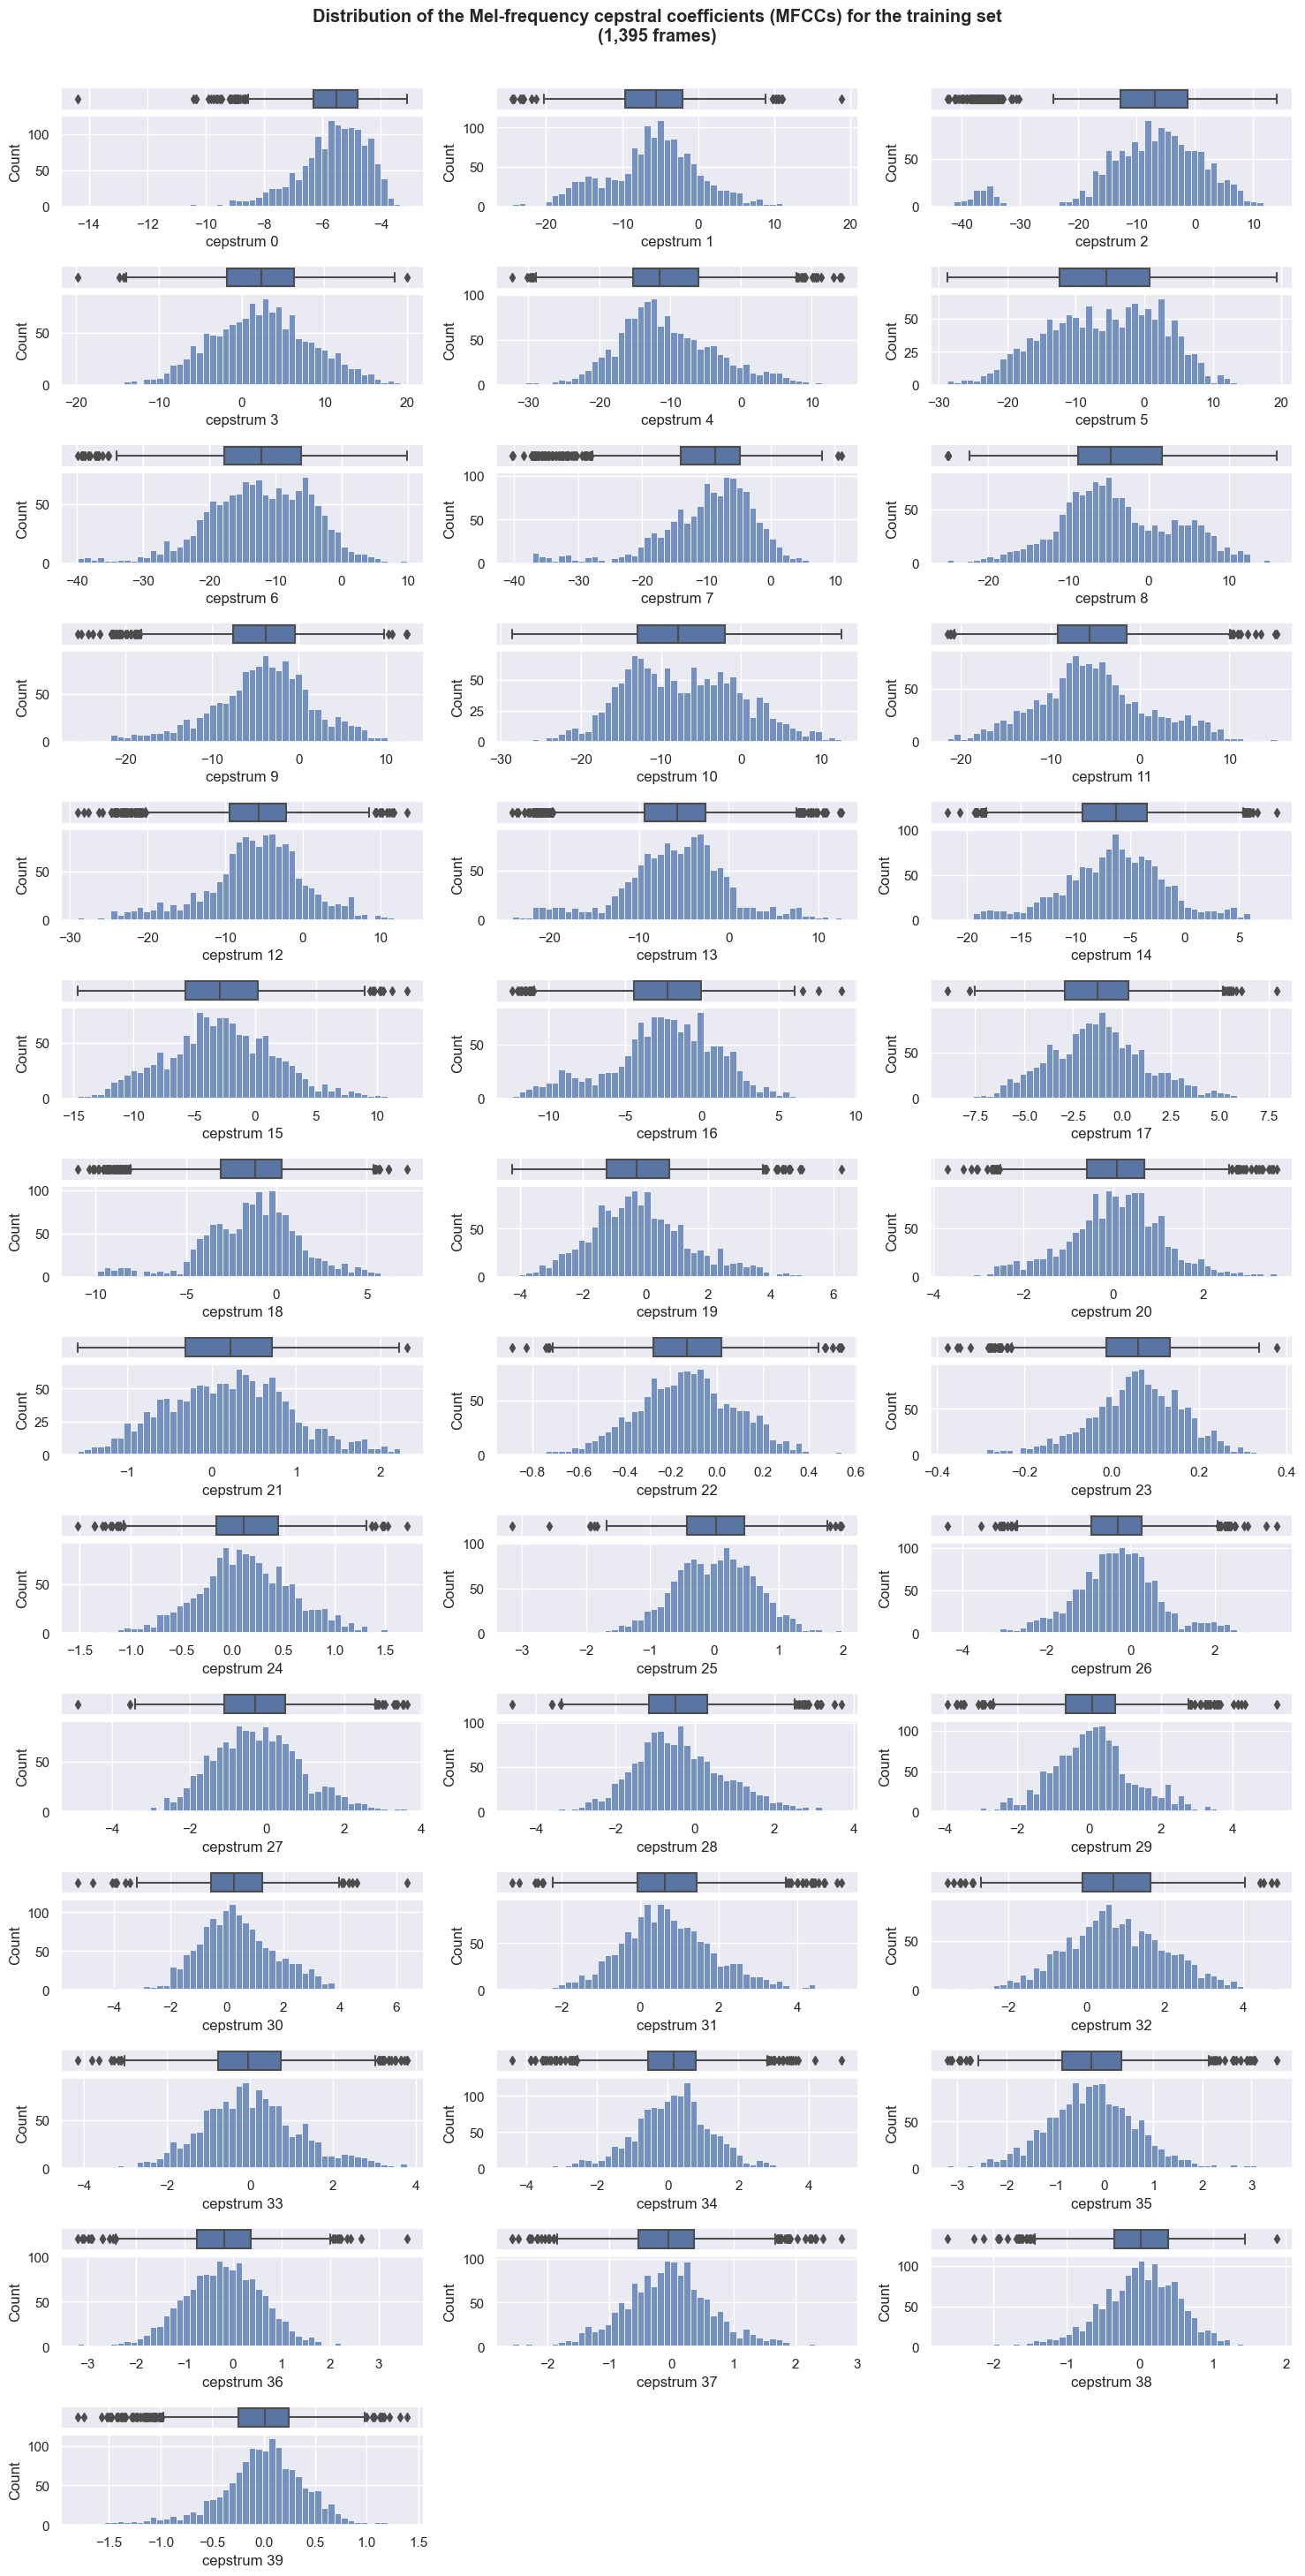

In [13]:
attr_list = ["cepstrum "+str(i) for i in range(0,NUMCEP)]
show_hist_box(X_train, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set", img_path="img/", do_save_to_disk=False, num_plots=NUMCEP)

#### Boxplots comparing male and female MFCCs distributions
According to [Emmanuel Deruty](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040), if a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. Therefore, since female voices are generally higher pitched than males', we expect to observe female distributions with lower cepstrum distributions than males'.

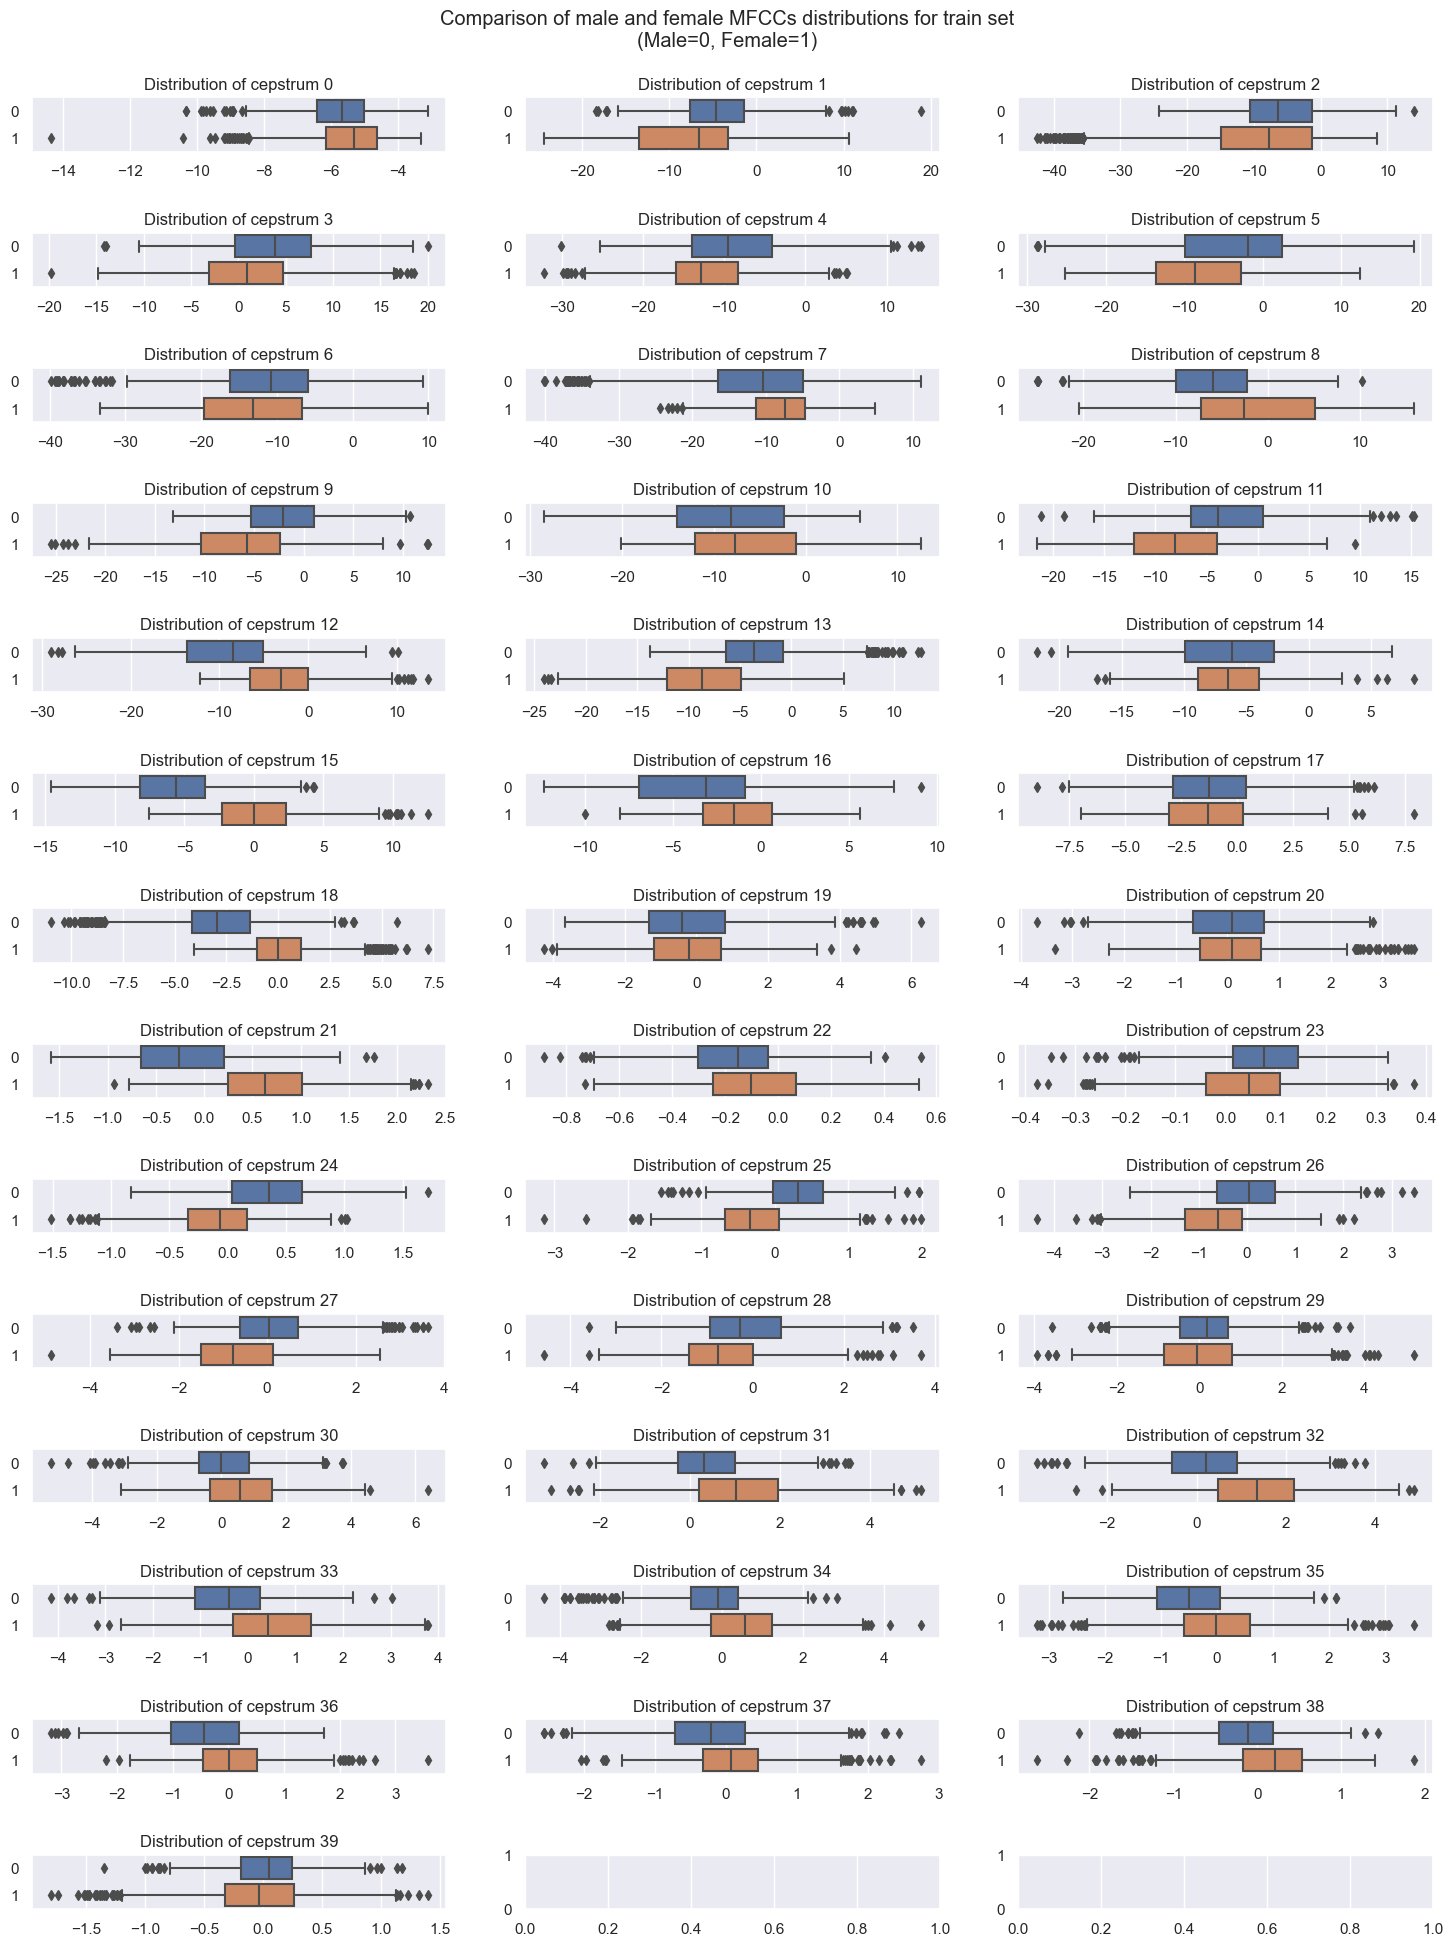

In [14]:
# Compare male and female data (before removing outliers)

male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

fig, axs = plt.subplots(nrows=math.ceil(NUMCEP/3), ncols=3, figsize=(15,20), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train[np.ix_(male_train_idx[0], [i])].T, X_train[np.ix_(female_train_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

In [15]:
cepstrum_fem_lt_male = []
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    male_ceptstrum_dist = X_train[np.ix_(male_train_idx[0], [i])].T 
    female_ceptstrum_dist = X_train[np.ix_(female_train_idx[0], [i])].T
    
    # add to list if female cepstrum mean less than male's cepstrum mean 
    if (female_ceptstrum_dist.mean() < male_ceptstrum_dist.mean()):
        cepstrum_fem_lt_male.append(i)
        
print(f"Female cepstrum mean is lower than Male cepstrum mean in {len(cepstrum_fem_lt_male)/len(attr_list):.2%} of the cases ({len(cepstrum_fem_lt_male)}/{len(attr_list)})")

Female cepstrum mean is lower than Male cepstrum mean in 50.00% of the cases (20/40)


**Observation:** Our observations did not confirm our intuition, as we observe the same amount of female distributions below as above the males ones. We especially see female cepstrum distributions higher than the male ones for higher cepstrum numbers. One of the reasons could be the presence of outliers.

### Detect outliers
We first try to detect Outliers using the Interquartile method, as follows:
- Multiply the interquartile range (IQR) by 1.5.
- Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
- Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

In [16]:
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train, 1.5)

• Q1: [ -6.31  -9.57 -12.73 ...  -0.53  -0.34  -0.24]
• Q3: [-4.81 -2.08 -1.29 ...  0.37  0.39  0.25]
• IQR:[ 1.5   7.48 11.44 ...  0.89  0.73  0.49]
• lower_bounds (Q1 - 1.5 * IQR): [ -8.55 -20.79 -29.88 ...  -1.86  -1.43  -0.98]
• upper_bounds (Q3 + 1.5 * IQR): [-2.56  9.14 15.87 ...  1.7   1.47  0.98]

Removed 680 outliers (48.7%)


**Observation:** This method suggests that almost half of our data points are outliers, which doesn't seem very realistic considering that we are using the "clean" subset of the LibriSpeech dataset. \
We will therefore relax the method a bit, by multiplying the IQR by 2 instead of 1.5, which removes about 18% of the dataset.

In [17]:
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train, 2)

• Q1: [ -6.31  -9.57 -12.73 ...  -0.53  -0.34  -0.24]
• Q3: [-4.81 -2.08 -1.29 ...  0.37  0.39  0.25]
• IQR:[ 1.5   7.48 11.44 ...  0.89  0.73  0.49]
• lower_bounds (Q1 - 2 * IQR): [ -9.3  -24.53 -35.6  ...  -2.31  -1.79  -1.23]
• upper_bounds (Q3 + 2 * IQR): [-1.81 12.88 21.59 ...  2.15  1.84  1.23]

Removed 248 outliers (17.8%)


#### Histograms of Male and Female together (without outliers)

In [18]:
show_hist_box(X_train_no_outliers, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False, num_plots=NUMCEP)

#### Boxplots comparing male and female MFCCs distributions (without outliers)

In [19]:
male_train_no_outliers_idx = np.where(y_train_no_outliers == 0)
female_train_no_outliers_idx = np.where(y_train_no_outliers == 1)

fig, axs = plt.subplots(nrows=math.ceil(NUMCEP/3), ncols=3, figsize=(15,20), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T, X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set, after removing outliers\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

In [20]:
cepstrum_fem_lt_male = []
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    male_ceptstrum_dist = X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T 
    female_ceptstrum_dist = X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T
    
    # add to list if female cepstrum mean less than male's cepstrum mean 
    if (female_ceptstrum_dist.mean() < male_ceptstrum_dist.mean()):
        cepstrum_fem_lt_male.append(i)
        
print(f"Female cepstrum mean is lower than Male cepstrum mean in {len(cepstrum_fem_lt_male)/len(attr_list):.2%} of the cases ({len(cepstrum_fem_lt_male)}/{len(attr_list)})")

Female cepstrum mean is lower than Male cepstrum mean in 47.50% of the cases (19/40)


**Observation:** Removing the outliers did not help with our intuition. If anything, it made it a bit worse.

### Normalize data

In [21]:
## if we decide to keep outliers after all
# X_train_no_outliers = X_train
# y_train_no_outliers = y_train

In [22]:
print("Before normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_no_outliers means: {np.mean(X_train_no_outliers, axis=0)}")
    print(f"• X_train_no_outliers std:   {np.std(X_train_no_outliers, axis=0)}")
    print(f"• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train_no_outliers, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\n\nAfter normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 
• X_train_no_outliers means: [-5.65 -5.78 -6.52 ... -0.05 -0.01 -0.01]
• X_train_no_outliers std:   [1.13 6.11 8.46 ... 0.71 0.53 0.4 ]
• X_test means:  [-5.29 -6.44 -9.56 ... -0.36 -0.23 -0.05]
• X_test std:    [1.2  7.26 9.13 ... 0.98 0.69 0.5 ]


After normalization: 
• X_train_norm means: [ 1.79e-15  4.46e-17 -7.58e-16 ...  4.33e-16  9.70e-17 -1.84e-17]
• X_train_norm std:   [1. 1. 1. ... 1. 1. 1.]
• X_test_norm means:  [-9.72e-15  4.47e-16  8.92e-16 ...  5.55e-17 -2.18e-16 -5.43e-17]
• X_test_norm std:    [1. 1. 1. ... 1. 1. 1.]


## Train ML models

### Naive Bayes classifier

In [23]:
clf = GaussianNB()
clf.fit(X_train_norm, y_train_no_outliers.ravel())
display(clf)

print("Gaussian Naive Bayes classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

GaussianNB()

Gaussian Naive Bayes classifier:
• Mean training accuracy:  94.42%
• Mean testing accuracy:   85.32%


In [24]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "Naive Bayes classifier\nConfusion Matrix for the Test set")
NB_metrics = compute_statistics(cf_matrix)

### Logistic Regression

In [25]:
clf = LogisticRegression(random_state=0)
display(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Logistic regression classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

LogisticRegression(random_state=0)

Logistic regression classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   88.15%


In [26]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "Logistic Regression classifier\nConfusion Matrix for the Test set")
LR_metrics = compute_statistics(cf_matrix)

### Support Vector Machines

In [27]:
print("SVM classifier:")
    
# Try training with different degrees of the polynomial kernel function
for degree in range(1,4):
    clf = svm.SVC(kernel='poly', degree=degree)
    display(clf)
    clf.fit(X_train_norm, y_train_no_outliers.ravel())
    
    # compute mean accuracy on the train data and labels.
    train_acc = clf.score(X_train_norm, y_train_no_outliers)
    print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

    # compute mean accuracy on the test data and labels.
    test_acc = clf.score(X_test_norm, y_test)
    print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
    print()

        
# RBF kernel
clf = svm.SVC(kernel='rbf')
display(clf)
clf.fit(X_train_norm, y_train_no_outliers.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers)
print(f"• Mean training accuracy (radial basis fucntion (rbf) kernel): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy  (radial basis fucntion (rbf) kernel): {test_acc:>7.2%}")
print()

SVM classifier:


SVC(degree=1, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 1):  99.39%
• Mean testing accuracy  (polynomial kernel of degree 1):  88.07%



SVC(degree=2, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 2): 100.00%
• Mean testing accuracy  (polynomial kernel of degree 2):  60.47%



SVC(kernel='poly')

• Mean training accuracy (polynomial kernel of degree 3): 100.00%
• Mean testing accuracy  (polynomial kernel of degree 3):  86.62%



SVC()

• Mean training accuracy (radial basis fucntion (rbf) kernel): 100.00%
• Mean testing accuracy  (radial basis fucntion (rbf) kernel):  90.06%



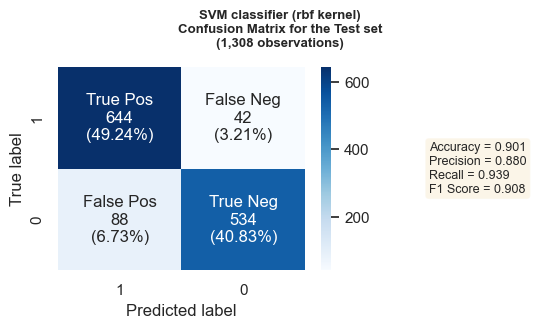

In [28]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "SVM classifier (rbf kernel)\nConfusion Matrix for the Test set")
SVM_metrics = compute_statistics(cf_matrix)

### Random Forest classifier

In [29]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
clf.fit(X_train_norm, y_train_no_outliers.ravel())
display(clf)

print("Random Forest classifier:")

train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

RandomForestClassifier(max_depth=4, random_state=0)

Random Forest classifier:
• Mean training accuracy:  99.04%
• Mean testing accuracy:   85.93%


In [30]:
start_time = time.time()

# parameters for GridSearch
param_grid = [{'n_estimators': [100,500,1000], 'max_features':['sqrt']}]

### Training and Evaluating Random Forest Regressor
clf = RandomForestClassifier()

#### Fine-Tune the model using Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=3)

grid_search.fit(X_train_norm, y_train_no_outliers.ravel())
best_clf = grid_search.best_estimator_
print(best_clf)

elapsed_time = time.time() - start_time
print(f"Elapsed time to train model: {elapsed_time:.3f} seconds")

train_acc = best_clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = best_clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.970) total time=   0.6s
[CV 2/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.835) total time=   0.5s
[CV 3/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.882) total time=   0.3s
[CV 4/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.725) total time=   0.4s
[CV 5/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.913) total time=   0.8s
[CV 1/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.974) total time=   2.1s
[CV 2/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.848) total time=   2.1s
[CV 3/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.886) total time=   2.2s
[CV 4/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.694) total time=   2.2s
[CV 5/5] END max_featu

In [31]:
y_pred = best_clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "RF classifier\nConfusion Matrix for the Test set")
RF_metrics = compute_statistics(cf_matrix)

### Neural Network

In [32]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10, 100, 100), activation='relu', alpha=0.0001, batch_size='auto', learning_rate_init=0.001, max_iter=100)
display(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Neural Network classifier:")

train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

MLPClassifier(hidden_layer_sizes=(10, 100, 100), max_iter=100, random_state=1)

Neural Network classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   82.19%


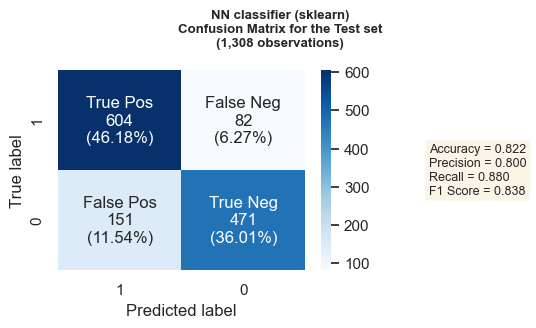

In [33]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "NN classifier (sklearn)\nConfusion Matrix for the Test set")
NNSK_metrics = compute_statistics(cf_matrix)

### Neural Network (PyTorch)

In [34]:
BATCH_SIZE = 128

In [35]:
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [36]:
class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(NUMCEP, 100)
        self.activation1 = torch.nn.ReLU()
        self.hidden_layer1 = torch.nn.Linear(100, 100)
        self.activation2 = torch.nn.ReLU()
        self.hidden_layer2 = torch.nn.Linear(100, 100)
        self.activation3 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(100, 1)
        self.activation_out = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.hidden_layer1(x)
        x = self.activation2(x)
        x = self.hidden_layer2(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        x = self.activation_out(x)
        return x

In [37]:
train_dataset = BinaryDataset(X_train_norm, y_train_no_outliers)
test_dataset = BinaryDataset(X_test_norm, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [38]:
model = NNClassifier().to(device)
print(model)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

NNClassifier(
  (input_layer): Linear(in_features=40, out_features=100, bias=True)
  (activation1): ReLU()
  (hidden_layer1): Linear(in_features=100, out_features=100, bias=True)
  (activation2): ReLU()
  (hidden_layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation3): ReLU()
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation_out): Sigmoid()
)


In [39]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (((y_pred > 0.5) * 1.0) == y_batch).sum().item()
        
        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)

        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [40]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # print("X_batch.shape: ", X_batch.shape)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()

            correct_epoch += (((y_pred > 0.5) * 1.0) == y_batch).sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [41]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=0.692 batch_acc=0.523 
Test set:  Average loss: 0.065, Accuracy: 697/1308 (53.3%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=0.651 batch_acc=0.672 
Test set:  Average loss: 0.060, Accuracy: 989/1308 (75.6%)

----------- Epoch Nr. 3 -----------
Train Epoch: 3-00 batch_loss=0.585 batch_acc=0.906 
Test set:  Average loss: 0.052, Accuracy: 1060/1308 (81.0%)

----------- Epoch Nr. 4 -----------
Train Epoch: 4-00 batch_loss=0.512 batch_acc=0.945 
Test set:  Average loss: 0.040, Accuracy: 1083/1308 (82.8%)

----------- Epoch Nr. 5 -----------
Train Epoch: 5-00 batch_loss=0.398 batch_acc=0.906 
Test set:  Average loss: 0.027, Accuracy: 1092/1308 (83.5%)

----------- Epoch Nr. 6 -----------
Train Epoch: 6-00 batch_loss=0.309 batch_acc=0.945 
Test set:  Average loss: 0.017, Accuracy: 1106/1308 (84.6%)

----------- Epoch Nr. 7 -----------
Train Epoch: 7-00 batch_loss=0.250 batch_acc=0.914 
Test set:  Average 

#### Plot train and test curves

In [42]:
n_train = len(train_acc_history)
t_train = NUM_EPOCHS * np.arange(n_train) / n_train
t_test = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(6.4 * 3, 4.8))
plt.subplot(1, 2, 1)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_test, test_acc_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_test, test_loss_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [43]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test_norm, dtype=torch.float))
    y_pred = (y_pred > 0.5) * 1.0
    
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "NN classifier (PyTorch)\nConfusion Matrix for the Test set")
NNPT_metrics = compute_statistics(cf_matrix)

### CNN

In [44]:
BATCH_SIZE = 128

In [45]:
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [46]:
class CNNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # CNN
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.activation01 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=1, kernel_size=5)
        self.activation02 = torch.nn.ReLU()
        self.pool = torch.nn.AdaptiveAvgPool1d(1)

        # MLP
        # self.input_layer = torch.nn.Linear(10, 100)
        # self.activation1 = torch.nn.ReLU()
        # self.hidden_layer1 = torch.nn.Linear(100, 100)
        # self.activation2 = torch.nn.ReLU()
        # self.hidden_layer2 = torch.nn.Linear(100, 100)
        # self.activation3 = torch.nn.ReLU()
        # self.output_layer = torch.nn.Linear(100, 1)
        self.activation_out = torch.nn.Sigmoid()
        
        self.flatten = torch.nn.Flatten()


    def forward(self, x):
        # CNN
        x = self.conv1(x)
        x = self.activation01(x)
        x = self.conv2(x)
        x = self.activation02(x)
        x = self.pool(x)

        # MLP
        # x = self.input_layer(x)
        # x = self.activation1(x)
        # x = self.hidden_layer1(x)
        # x = self.activation2(x)
        # x = self.hidden_layer2(x)
        # x = self.activation3(x)
        # x = self.output_layer(x)
        x = self.activation_out(x)
        
        x = self.flatten(x)
        return x

In [47]:
train_dataset = BinaryDataset(X_train_norm, y_train_no_outliers)
test_dataset = BinaryDataset(X_test_norm, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [48]:
model = CNNClassifier().to(device)
print(model)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

CNNClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (activation01): ReLU()
  (conv2): Conv1d(32, 1, kernel_size=(5,), stride=(1,))
  (activation02): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (activation_out): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


CNN input size: (N, Cin, L), output size: (N, Cout, L). N is a batch size, C denotes a number of channels, L is a length of signal sequence

In [49]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    print("len(dataloader): ", len(dataloader))
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # print("X_batch.shape: ", X_batch.shape)
        X_batch = torch.unsqueeze(X_batch, dim=1)
        # print("X_batch.shape after unsqueezing: ", X_batch.shape)
        # print()
        y_pred = model(X_batch)
        
        # print("y_pred.shape: ", y_pred.shape)
        # print("y_batch.shape: ", y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (((y_pred > 0.5) * 1.0) == y_batch).sum().item()
        
        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)
        
        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [50]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            
            X_batch = torch.unsqueeze(X_batch, dim=1)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()

            correct_epoch += (((y_pred > 0.5) * 1.0) == y_batch).sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [51]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
len(dataloader):  9
Train Epoch: 1-00 batch_loss=0.693 batch_acc=0.555 
Test set:  Average loss: 0.063, Accuracy: 645/1308 (49.3%)

----------- Epoch Nr. 2 -----------
len(dataloader):  9
Train Epoch: 2-00 batch_loss=0.693 batch_acc=0.508 
Test set:  Average loss: 0.063, Accuracy: 611/1308 (46.7%)

----------- Epoch Nr. 3 -----------
len(dataloader):  9
Train Epoch: 3-00 batch_loss=0.693 batch_acc=0.531 
Test set:  Average loss: 0.063, Accuracy: 613/1308 (46.9%)

----------- Epoch Nr. 4 -----------
len(dataloader):  9
Train Epoch: 4-00 batch_loss=0.693 batch_acc=0.570 
Test set:  Average loss: 0.063, Accuracy: 630/1308 (48.2%)

----------- Epoch Nr. 5 -----------
len(dataloader):  9
Train Epoch: 5-00 batch_loss=0.693 batch_acc=0.594 
Test set:  Average loss: 0.063, Accuracy: 672/1308 (51.4%)

----------- Epoch Nr. 6 -----------
len(dataloader):  9
Train Epoch: 6-00 batch_loss=0.693 batch_acc=0.547 
Test set:  Average loss: 0.063, Accuracy: 713/1308 

In [52]:
# model.eval()
# with torch.no_grad():
#     y_pred = model(torch.tensor(X_test_norm, dtype=torch.float))
#     y_pred = (y_pred > 0.5) * 1.0
    
# cf_matrix = confusion_matrix(y_test, y_pred)
# fig = show_confusion_matrix(cf_matrix, "CNN classifier (PyTorch)\nConfusion Matrix for the Test set")
# accuracy_CNN, precision_CNN, recall_CNN, f1_score_CNN = compute_statistics(cf_matrix)

## Compare ML models

In [53]:
metrics_data = np.array([NB_metrics, LR_metrics, SVM_metrics, RF_metrics, NNSK_metrics, NNPT_metrics])

df = pd.DataFrame(metrics_data, columns=["Accuracy", "Precision", "Recall", "F1-Score"])
df.index = ['NB', 'LR', 'SVM', 'RF', 'NN (SK)', 'NN (PT)']

with pd.option_context('display.precision', 3):
    display(df)

Accuracy  Precision  Recall  F1-Score
NB          0.853      0.856   0.866     0.861
LR          0.881      0.883   0.892     0.888
SVM         0.901      0.880   0.939     0.908
RF          0.869      0.863   0.891     0.877
NN (SK)     0.822      0.800   0.880     0.838
NN (PT)     0.880      0.850   0.936     0.891

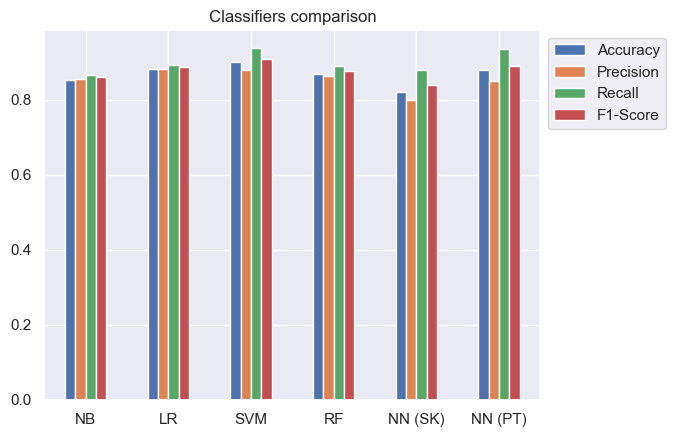

In [54]:
ax = df.plot.bar(rot=0)
ax.set_title("Classifiers comparison")
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

**Conclusion:** All classifiers perform quite well (all metrics are over 80%). The best one is the SVM, with an accuracy of 90%, and a recall of 93.9%.

### Visualisation

Let's try to find patterns by visualizing our dataset using PCA dimensionality reduction.

#### Reduce dimensionality to 2 dimensions using PCA

In [55]:
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,147 samples, 2 dimensions
• Reduced test set:  1,308 samples, 2 dimensions


In [56]:
# run K-means algorithm on reduced train set with 2 clusters (for male and female)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=2)
kmeans.fit(reduced_X_train)
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [57]:
train_acc = (kmeans.predict(reduced_X_train) == y_train_no_outliers.ravel()).sum() / len(y_train_no_outliers)
print(f"• Mean testing accuracy:  {train_acc:>7.2%}")

test_acc = (kmeans.predict(reduced_X_test) == y_test.ravel()).sum() / len(y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

• Mean testing accuracy:   85.18%
• Mean testing accuracy:   14.76%


#### Visualize the results on PCA-reduced data

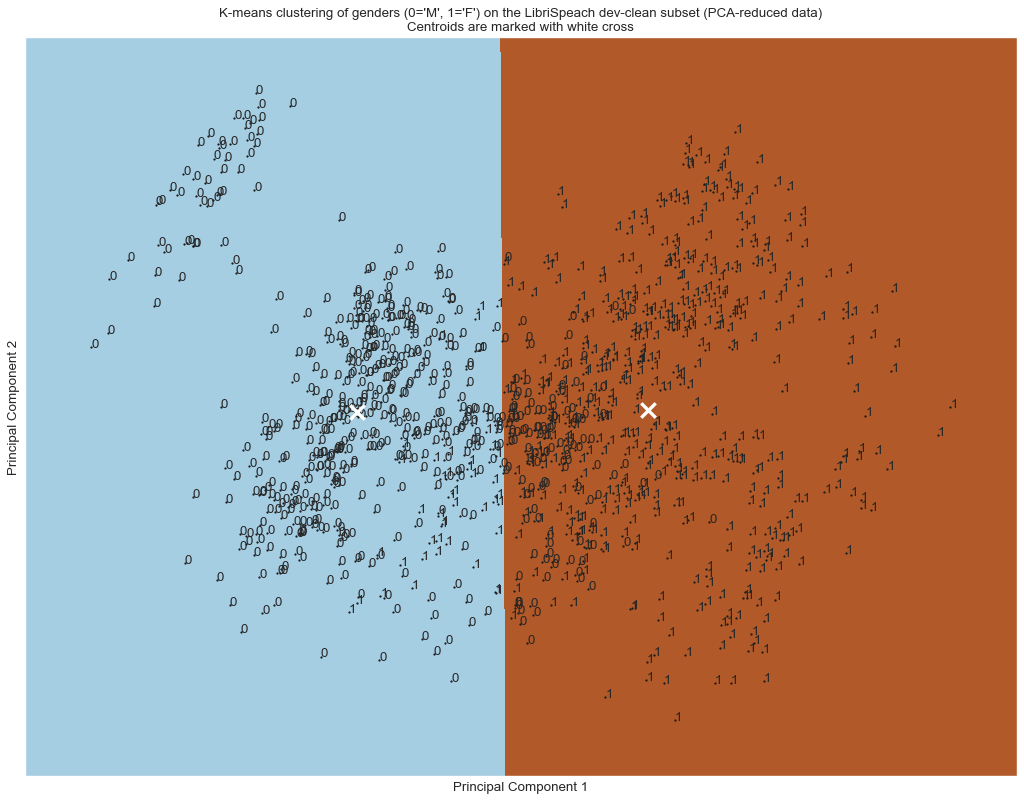

In [58]:
figure(figsize=(16, 12), dpi=80)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_X_train[:, 0].min() - 1, reduced_X_train[:, 0].max() + 1
y_min, y_max = reduced_X_train[:, 1].min() - 1, reduced_X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired, aspect="auto", origin="lower")
plt.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], "k.", markersize=2)

# annotate each point with its corresponding gender label
for i, l in enumerate(y_train_no_outliers.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3, color="w", zorder=10)

plt.title(
    f"K-means clustering of genders (0='M', 1='F') on the LibriSpeach dev-clean subset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()

**Obervation:** We can see a pretty clear separation betwen both genders.

# Part 2. Speaker Classification from audio files

In this part, we try to predict who is the speaker of an audio file, by training a multi-class classifier on previous audio files of these speakers. This time, we will use the [wav2vec 2.0]((https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/README.md)) base model (No Finetuning), and use to extract features from audio signals. We will use the same audio files as we used in the previous task, however this time, we will apply the model on 2 seconds subsequent chunks instead of extracting the features from the whole audio file at once.

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [60]:
# # wav2vec 2.0 - the following code has been modified to work with fairseq Version: 0.10.2, see https://github.com/facebookresearch/fairseq/issues/3134
# wav2vec2_checkpoint_path = './models/wav2vec_small.pt'
# checkpoint = torch.load(wav2vec2_checkpoint_path)
# wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(checkpoint['args'])
# wav2vec2_encoder.load_state_dict(checkpoint['model'])

In [61]:
# wav2vec 2.0  - the following code has been modified to work with fairseq Version: 0.12.2, see https://github.com/facebookresearch/fairseq/issues/3134
wav2vec2_checkpoint_path = './models/wav2vec_small.pt'
checkpoint = torch.load(wav2vec2_checkpoint_path)
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model).to(device)

### Extract wav2vec features from audio files

In [62]:
NUM_FEATURES = 768

In [63]:
def extract_wav2vec_features(speaker_id, device):
    speaker_features = np.zeros((0, NUM_FEATURES))  # create new array for features for this speaker
    speaker_audio_file_count = 0 
    
    speaker_path = DEV_CLEAN + str(speaker_id)
    
    for path in tqdm(glob.glob(f'{speaker_path}/*/*.flac', recursive=True), desc=f"Speaker {speaker_id:>4}"):        
        file_features = torch.zeros(1, 0, NUM_FEATURES).to(device)
        with open(path, 'rb') as f:
            data, samplerate = sf.read(f)  
            
            # read chunks of 2 seconds (2 x 16,000 frames/sec)
            blocks = sf.blocks(path, blocksize=32_000)  
            for block in blocks:
                if block.shape[0] < 400:
                  # prevent "Kernel size can't be greater than actual input size" error
                  print(f"    error: block of {block.shape[0]} frames too small - discard it")
                  continue
                block_tensor = torch.from_numpy(block).to(torch.float32)
                block_tensor = torch.unsqueeze(block_tensor, dim=0).to(device)
                # print(block_tensor.shape)
                block_features = wav2vec2_encoder(block_tensor, features_only=True, mask=False)['x']
                
                # concatenate features for current file
                file_features = torch.cat((file_features, block_features.to(device)), dim=1)


        # data_tensor = torch.from_numpy(data).to(torch.float32)
        # data_tensor = torch.unsqueeze(data_tensor, dim=0)
        # file_features = wav2vec2_encoder(data_tensor, features_only=True, mask=False)['x']

        file_features_mean = torch.mean(file_features, dim=1).detach().cpu().numpy()
        speaker_features = np.vstack((speaker_features, file_features_mean))
        
        speaker_audio_file_count += 1
    print(f"Speaker {speaker_id:>4}:", end=" ")
    print(f"{speaker_audio_file_count:>3} audio files", end=", ")

    return speaker_features

In [64]:
def build_dataset_wav2vec(speaker_ids, speakers_gender, device):
    
    dataset = np.zeros((0,NUM_FEATURES+2))  # dataset is comprised of 13 features (MFCCs) + speaker id + label

    for i, speaker_id in enumerate(tqdm(speaker_ids, desc='Extracting features')):
        
        speaker_features = extract_wav2vec_features(speaker_id, device)
        
        if SPEAKER_MEAN_MFCCs == True:
            # take the mean of the mfcc's for each speaker
            speaker_features = np.expand_dims(np.mean(speaker_features, axis=0), axis=1).T   
        

        # Adding speaker id column to 2D NumPy Array
        speaker_id_col = np.empty(speaker_features.shape[0])
        speaker_id_col.fill(speaker_id)
        speaker_features_meta_1 = np.column_stack((speaker_features, speaker_id_col))

        # gender column to be added for this user
        gender = speakers_gender[int(speaker_id)]
        print(f"gender {gender} {'(M)' if gender==0 else '(F)'}")

        # Adding gender column to 2D NumPy Array
        gender_col = np.empty(speaker_features.shape[0])
        gender_col.fill(gender)
        speaker_features_meta_2 = np.column_stack((speaker_features_meta_1, gender_col))

        # add this user to all users
        dataset = np.vstack((dataset, speaker_features_meta_2))

    return dataset

In [65]:
# Extracting the features with wav2vec takes quite a lot of time when run on cpu, so I ran it in on a GPU in Google collab, and saved the resulting files to disk (see next cell)

# start_time = time.time()

# print("Build wav2vec train dataset: ")
# wav2vec_train_dataset = build_dataset_wav2vec(male_ids_train + female_ids_train, speakers_gender, device)
# print(wav2vec_train_dataset.shape, "\n")

# print("Build wav2vec test dataset: ")
# wav2vec_test_dataset = build_dataset_wav2vec(male_ids_test + female_ids_test, speakers_gender, device)
# print(wav2vec_test_dataset.shape, "\n")

# elapsed_time = time.time() - start_time
# print(f"Elapsed time to build the dataset: {elapsed_time:.3f} seconds")

# # save dataset to disk
# np.savetxt('/content/drive/MyDrive/Voiseed/data/wav2vec_train_dataset.csv', wav2vec_train_dataset, delimiter=',')
# np.savetxt('/content/drive/MyDrive/Voiseed/data/wav2vec_test_dataset.csv', wav2vec_test_dataset, delimiter=',')

# # verify files have been successfully saved
# !ls -lh /content/drive/MyDrive/Voiseed/data/

### Merge train and test

The split from the previous cell was not ideal. Since it took too long to re-extract the features, I kept them, but merged the previously split files and re-did the splits in an improved manner.

In [66]:
# load datasets from disk
wav2vec_old_train_dataset = np.loadtxt('./data/wav2vec_train_dataset.csv', delimiter=',')
wav2vec_old_test_dataset = np.loadtxt('./data/wav2vec_test_dataset.csv', delimiter=',')
wav2vec_dataset = np.vstack((wav2vec_old_train_dataset, wav2vec_old_test_dataset))

In [67]:
# merge train and test
print("old train shape: ", wav2vec_old_train_dataset.shape)
print("old test shape:  ", wav2vec_old_test_dataset.shape)
print("merge shape:     ", wav2vec_dataset.shape)

old train shape:  (1242, 770)
old test shape:   (1461, 770)
merge shape:      (2703, 770)


### Train / Test split

In this split, we ensure that each speaker is present in both the Train and Test sets, however, we **ensure that each audio file is in one of the sets only (no leakage)**.

In [68]:
def train_test_split(speaker, train_ratio):
    
    # get all indexes of the specified speaker in dataset
    speaker_indexes = np.where(wav2vec_dataset[:, -2] == speaker_id)[0]
    
    # get the total nb of files of this speaker
    nb_speaker_files = len(speaker_indexes)
    
    # compute the nb of this speaker's files that will go in the test set
    nb_speaker_train_files = math.ceil(nb_speaker_files * train_ratio)
    
    # split the train and test indexes accordingly
    train_idx = speaker_indexes[:nb_speaker_train_files]
    test_idx = speaker_indexes[nb_speaker_train_files:]

    return wav2vec_dataset[train_idx], wav2vec_dataset[test_idx]

In [69]:
TRAIN_RATIO = 0.7

# get all speakers ids in the dataset
speakers = [int(speaker) for speaker in set(wav2vec_dataset[:, -2])]

# create 2 empty datasets for train and test sets
wav2vec_train_dataset = np.zeros((0, NUM_FEATURES + 2))
wav2vec_test_dataset = np.zeros((0, NUM_FEATURES + 2))

# perform the split for each speaker, and add extracted features and corresponding labels to respective datasets
for speaker_id in speakers:
    speaker_train_set, speaker_test_set = train_test_split(speaker_id, TRAIN_RATIO)
    wav2vec_train_dataset = np.vstack((wav2vec_train_dataset, speaker_train_set))
    wav2vec_test_dataset = np.vstack((wav2vec_test_dataset, speaker_test_set))

print(wav2vec_train_dataset.shape)
print(wav2vec_test_dataset.shape)

(1909, 770)
(794, 770)


In [70]:
print("Dataset basic statistics:")
print(f"• Training set: nb audio files: {wav2vec_train_dataset.shape[0]:>5,}; nb features: {wav2vec_train_dataset.shape[1]-2}; nb speakers: {len(set(wav2vec_train_dataset[:, -2]))}, M/F ratio: {(wav2vec_train_dataset[:, -1] == 0).sum()} / {(wav2vec_train_dataset[:, -1] == 1).sum()}")
print(f"• Testing  set: nb audio files: {wav2vec_test_dataset.shape[0]:>5,}; nb features: {wav2vec_test_dataset.shape[1]-2}; nb speakers: {len(set(wav2vec_test_dataset[:, -2]))}, M/F ratio: {(wav2vec_test_dataset[:, -1] == 0).sum()} / {(wav2vec_test_dataset[:, -1] == 1).sum()}")

Dataset basic statistics:
• Training set: nb audio files: 1,909; nb features: 768; nb speakers: 40, M/F ratio: 940 / 969
• Testing  set: nb audio files:   794; nb features: 768; nb speakers: 40, M/F ratio: 389 / 405


### Separate features and label

In [71]:
X_train = wav2vec_train_dataset[:, :NUM_FEATURES]
y_train_gender = wav2vec_train_dataset[:, [-1]]
y_train_speaker = wav2vec_train_dataset[:, [-2]]

X_test = wav2vec_test_dataset[:, :NUM_FEATURES]
y_test_gender = wav2vec_test_dataset[:, [-1]]
y_test_speaker = wav2vec_test_dataset[:, [-2]]

X_train.shape, y_train_gender.shape, y_train_speaker.shape, X_test.shape, y_test_gender.shape, y_test_speaker.shape, 

((1909, 768), (1909, 1), (1909, 1), (794, 768), (794, 1), (794, 1))

## EDA

In [72]:
male_train_idx = np.where(y_train_gender == 0)
female_train_idx = np.where(y_train_gender == 1)

male_test_idx = np.where(y_test_gender == 0)
female_test_idx = np.where(y_test_gender == 1)

total_files = len(X_train)+len(X_test)

print(f"Total audio files in dataset:   {total_files:>6,}")
print()
print(f"Audio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
print(f"• Male files:                   {len(male_train_idx[0]):>6,}")
print(f"• Female files:                 {len(female_train_idx[0]):>6,}")
print()
print(f"Audio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
print(f"• Male files:                   {len(male_test_idx[0]):>6,}")
print(f"• Female files:                 {len(female_test_idx[0]):>6,}")

Total audio files in dataset:    2,703

Audio files in train dataset:    1,909 (70.63%)
• Male files:                      940
• Female files:                    969

Audio files in test dataset:       794 (29.37%)
• Male files:                      389
• Female files:                    405


### Normalize data

In [73]:
print("Before normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train means: {np.mean(X_train, axis=0)}")
    print(f"• X_train std:   {np.std(X_train, axis=0)}")
    print(f"• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\nAfter normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 
• X_train means: [ 0.08  0.3  -0.75 ... -0.3  -0.1  -0.37]
• X_train std:   [0.15 0.13 0.19 ... 0.16 0.15 0.17]
• X_test means:  [ 0.08  0.31 -0.74 ... -0.3  -0.1  -0.38]
• X_test std:    [0.15 0.14 0.19 ... 0.16 0.15 0.17]

After normalization: 
• X_train_norm means: [ 1.41e-16  2.11e-16  2.21e-16 ...  5.50e-17  5.22e-17 -1.31e-16]
• X_train_norm std:   [1. 1. 1. ... 1. 1. 1.]
• X_test_norm means:  [ 4.19e-18 -4.69e-17  2.37e-16 ... -6.60e-17  3.38e-17 -1.01e-16]
• X_test_norm std:    [1. 1. 1. ... 1. 1. 1.]


## A. Quantitative analysis, using prediction models

### Multinomial Logistic Regression

In [74]:
clf = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000)
display(clf)

clf.fit(X_train_norm, y_train_speaker.ravel())

print("Logistic regression classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

Logistic regression classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   74.06%


### Support Vector Machines

In [75]:
print("SVM classifier:")
    
# RBF kernel
clf = svm.SVC(kernel='rbf')
display(clf)
clf.fit(X_train_norm, y_train_speaker.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_speaker)
print(f"• Mean training accuracy (radial basis fucntion (rbf) kernel): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy  (radial basis fucntion (rbf) kernel): {test_acc:>7.2%}")
print()
    
    
# Try training with different degrees of the polynomial kernel function
for degree in range(1,4):
    clf = svm.SVC(kernel='poly', degree=degree)
    display(clf)
    clf.fit(X_train_norm, y_train_speaker.ravel())
    
    # compute mean accuracy on the train data and labels.
    train_acc = clf.score(X_train_norm, y_train_speaker)
    print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

    # compute mean accuracy on the test data and labels.
    test_acc = clf.score(X_test_norm, y_test_speaker)
    print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
    print()

SVM classifier:


SVC()

• Mean training accuracy (radial basis fucntion (rbf) kernel):  99.48%
• Mean testing accuracy  (radial basis fucntion (rbf) kernel):  61.34%



SVC(degree=1, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 1):  95.86%
• Mean testing accuracy  (polynomial kernel of degree 1):  69.90%



SVC(degree=2, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 2):  76.58%
• Mean testing accuracy  (polynomial kernel of degree 2):  27.33%



SVC(kernel='poly')

• Mean training accuracy (polynomial kernel of degree 3):  58.51%
• Mean testing accuracy  (polynomial kernel of degree 3):  15.49%



### Random Forest classifier

In [76]:
# clf = RandomForestClassifier(n_estimators=100, random_state=0)
# clf.fit(X_train_norm, y_train_speaker.ravel())
# display(clf)

# print("Random Forest classifier:")

# train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
# print(f"• Mean training accuracy: {train_acc:>7.2%}")

# test_acc = clf.score(X_test_norm, y_test_speaker)
# print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

Fine tune hyperparameters using Grid Search Cross Validation

In [77]:
start_time = time.time()

print("Random Forest classifier (fine tune hyperparams using Grid Search CV):")

# parameters for GridSearch
param_grid = [{'n_estimators': [100, 200, 1000], 'max_features':['sqrt']}]

### Training and Evaluating Random Forest Regressor
clf = RandomForestClassifier()

#### Fine-Tune the model using Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=2, scoring="accuracy", return_train_score=True, verbose=3)

grid_search.fit(X_train_norm, y_train_speaker.ravel())
best_clf = grid_search.best_estimator_

elapsed_time = time.time() - start_time
print(f"Elapsed time to train model: {elapsed_time:.3f} seconds")

print(f"\nBest model ({best_clf.n_estimators} trees): ")

train_acc = best_clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = best_clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

Random Forest classifier (fine tune hyperparams using Grid Search CV):
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.385) total time=   3.2s
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.377) total time=   3.3s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.426) total time=   8.1s
[CV 2/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.412) total time=   7.0s
[CV 1/2] END max_features=sqrt, n_estimators=1000;, score=(train=1.000, test=0.488) total time=  33.5s
[CV 2/2] END max_features=sqrt, n_estimators=1000;, score=(train=1.000, test=0.454) total time=  32.6s
Elapsed time to train model: 159.613 seconds

Best model (1000 trees): 
• Mean training accuracy: 100.00%
• Mean testing accuracy:   55.16%


### Neural Network

In [78]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(1000, 100), activation='relu', alpha=0.0001, batch_size='auto', learning_rate_init=0.001, max_iter=200)
display(clf)

clf.fit(X_train_norm, y_train_speaker.ravel())

print("Neural Network classifier:")

train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

MLPClassifier(hidden_layer_sizes=(1000, 100), random_state=1)

Neural Network classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   72.42%


### Neural Network (PyTorch)

In [79]:
# one hot encode the different categories (1 per speaker)

# speakers of entire dataset
y_speaker = wav2vec_dataset[:, [-2]]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_speaker)
print("Categories / speakers: \n", ohe.categories_[0])
 
y_train_speaker_ohe = ohe.transform(y_train_speaker)
print(f"y_train speaker dimensions (OHE): {y_train_speaker_ohe.shape}")

y_test_speaker_ohe = ohe.transform(y_test_speaker)
print(f"y_test speaker dimensions (OHE): {y_test_speaker_ohe.shape}")


Categories / speakers: 
 [  84.  174.  251.  422.  652.  777. 1272. 1462. 1673. 1919. 1988. 1993.
 2035. 2078. 2086. 2277. 2412. 2428. 2803. 2902. 3000. 3081. 3170. 3536.
 3576. 3752. 3853. 5338. 5536. 5694. 5895. 6241. 6295. 6313. 6319. 6345.
 7850. 7976. 8297. 8842.]
y_train speaker dimensions (OHE): (1909, 40)
y_test speaker dimensions (OHE): (794, 40)


In [80]:
BATCH_SIZE = 128

In [81]:
class MultiClassDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [82]:
class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(NUM_FEATURES, 1000)
        self.activation1 = torch.nn.ReLU()
        self.hidden_layer1 = torch.nn.Linear(1000, 100)
        self.activation2 = torch.nn.ReLU()
        self.hidden_layer2 = torch.nn.Linear(100, 100)
        self.activation3 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(100, len(ohe.categories_[0]))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.hidden_layer1(x)
        x = self.activation2(x)
        x = self.hidden_layer2(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        return x

In [83]:
train_dataset = MultiClassDataset(X_train_norm, y_train_speaker_ohe)
test_dataset = MultiClassDataset(X_test_norm, y_test_speaker_ohe)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [84]:
model = NNClassifier().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

NNClassifier(
  (input_layer): Linear(in_features=768, out_features=1000, bias=True)
  (activation1): ReLU()
  (hidden_layer1): Linear(in_features=1000, out_features=100, bias=True)
  (activation2): ReLU()
  (hidden_layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation3): ReLU()
  (output_layer): Linear(in_features=100, out_features=40, bias=True)
)


In [85]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().sum().item()

        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)
        
        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [86]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()
            
            correct_epoch += (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [87]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=3.679 batch_acc=0.039 
Train Epoch: 1-10 batch_loss=3.369 batch_acc=0.156 
Test set:  Average loss: 0.505, Accuracy: 157.0/794 (19.8%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=2.842 batch_acc=0.273 
Train Epoch: 2-10 batch_loss=2.097 batch_acc=0.453 
Test set:  Average loss: 0.381, Accuracy: 342.0/794 (43.1%)

----------- Epoch Nr. 3 -----------
Train Epoch: 3-00 batch_loss=1.562 batch_acc=0.602 
Train Epoch: 3-10 batch_loss=1.148 batch_acc=0.734 
Test set:  Average loss: 0.306, Accuracy: 453.0/794 (57.1%)

----------- Epoch Nr. 4 -----------
Train Epoch: 4-00 batch_loss=0.890 batch_acc=0.781 
Train Epoch: 4-10 batch_loss=0.576 batch_acc=0.844 
Test set:  Average loss: 0.180, Accuracy: 511.0/794 (64.4%)

----------- Epoch Nr. 5 -----------
Train Epoch: 5-00 batch_loss=0.461 batch_acc=0.906 
Train Epoch: 5-10 batch_loss=0.416 batch_acc=0.922 
Test set:  Average loss: 0.130, Accuracy: 525.0/794 (66

#### Plot train and test curves

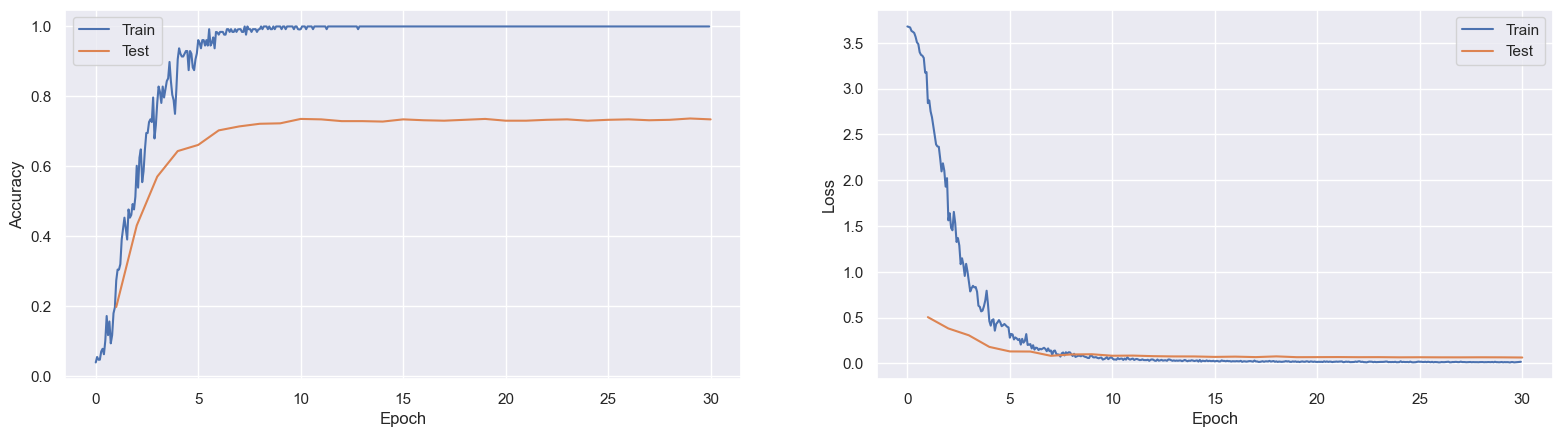

In [88]:
n_train = len(train_acc_history)
t_train = NUM_EPOCHS * np.arange(n_train) / n_train
t_test = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(6.4 * 3, 4.8))
plt.subplot(1, 2, 1)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_test, test_acc_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_test, test_loss_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## B. Qualitative analysis
In this section, we perform a qualitative analysis, by using algorithms of dimensionality reduction and clustering and visualizing the results.

#### PCA analysis

Since we a have extracted a high number of dimensions/features per observation (768), we will use Principal component analysis (PCA) to try to analyzing and interpret our dataset. \
We will use the first two principal components in order to plot the data in two dimensions and try to visually identify clusters of closely related data points.

In [89]:
# Reduce our dimensionality using Singular Value Decomposition project the data into to a 2 dimensional space. 
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,909 samples, 2 dimensions
• Reduced test set:  794 samples, 2 dimensions


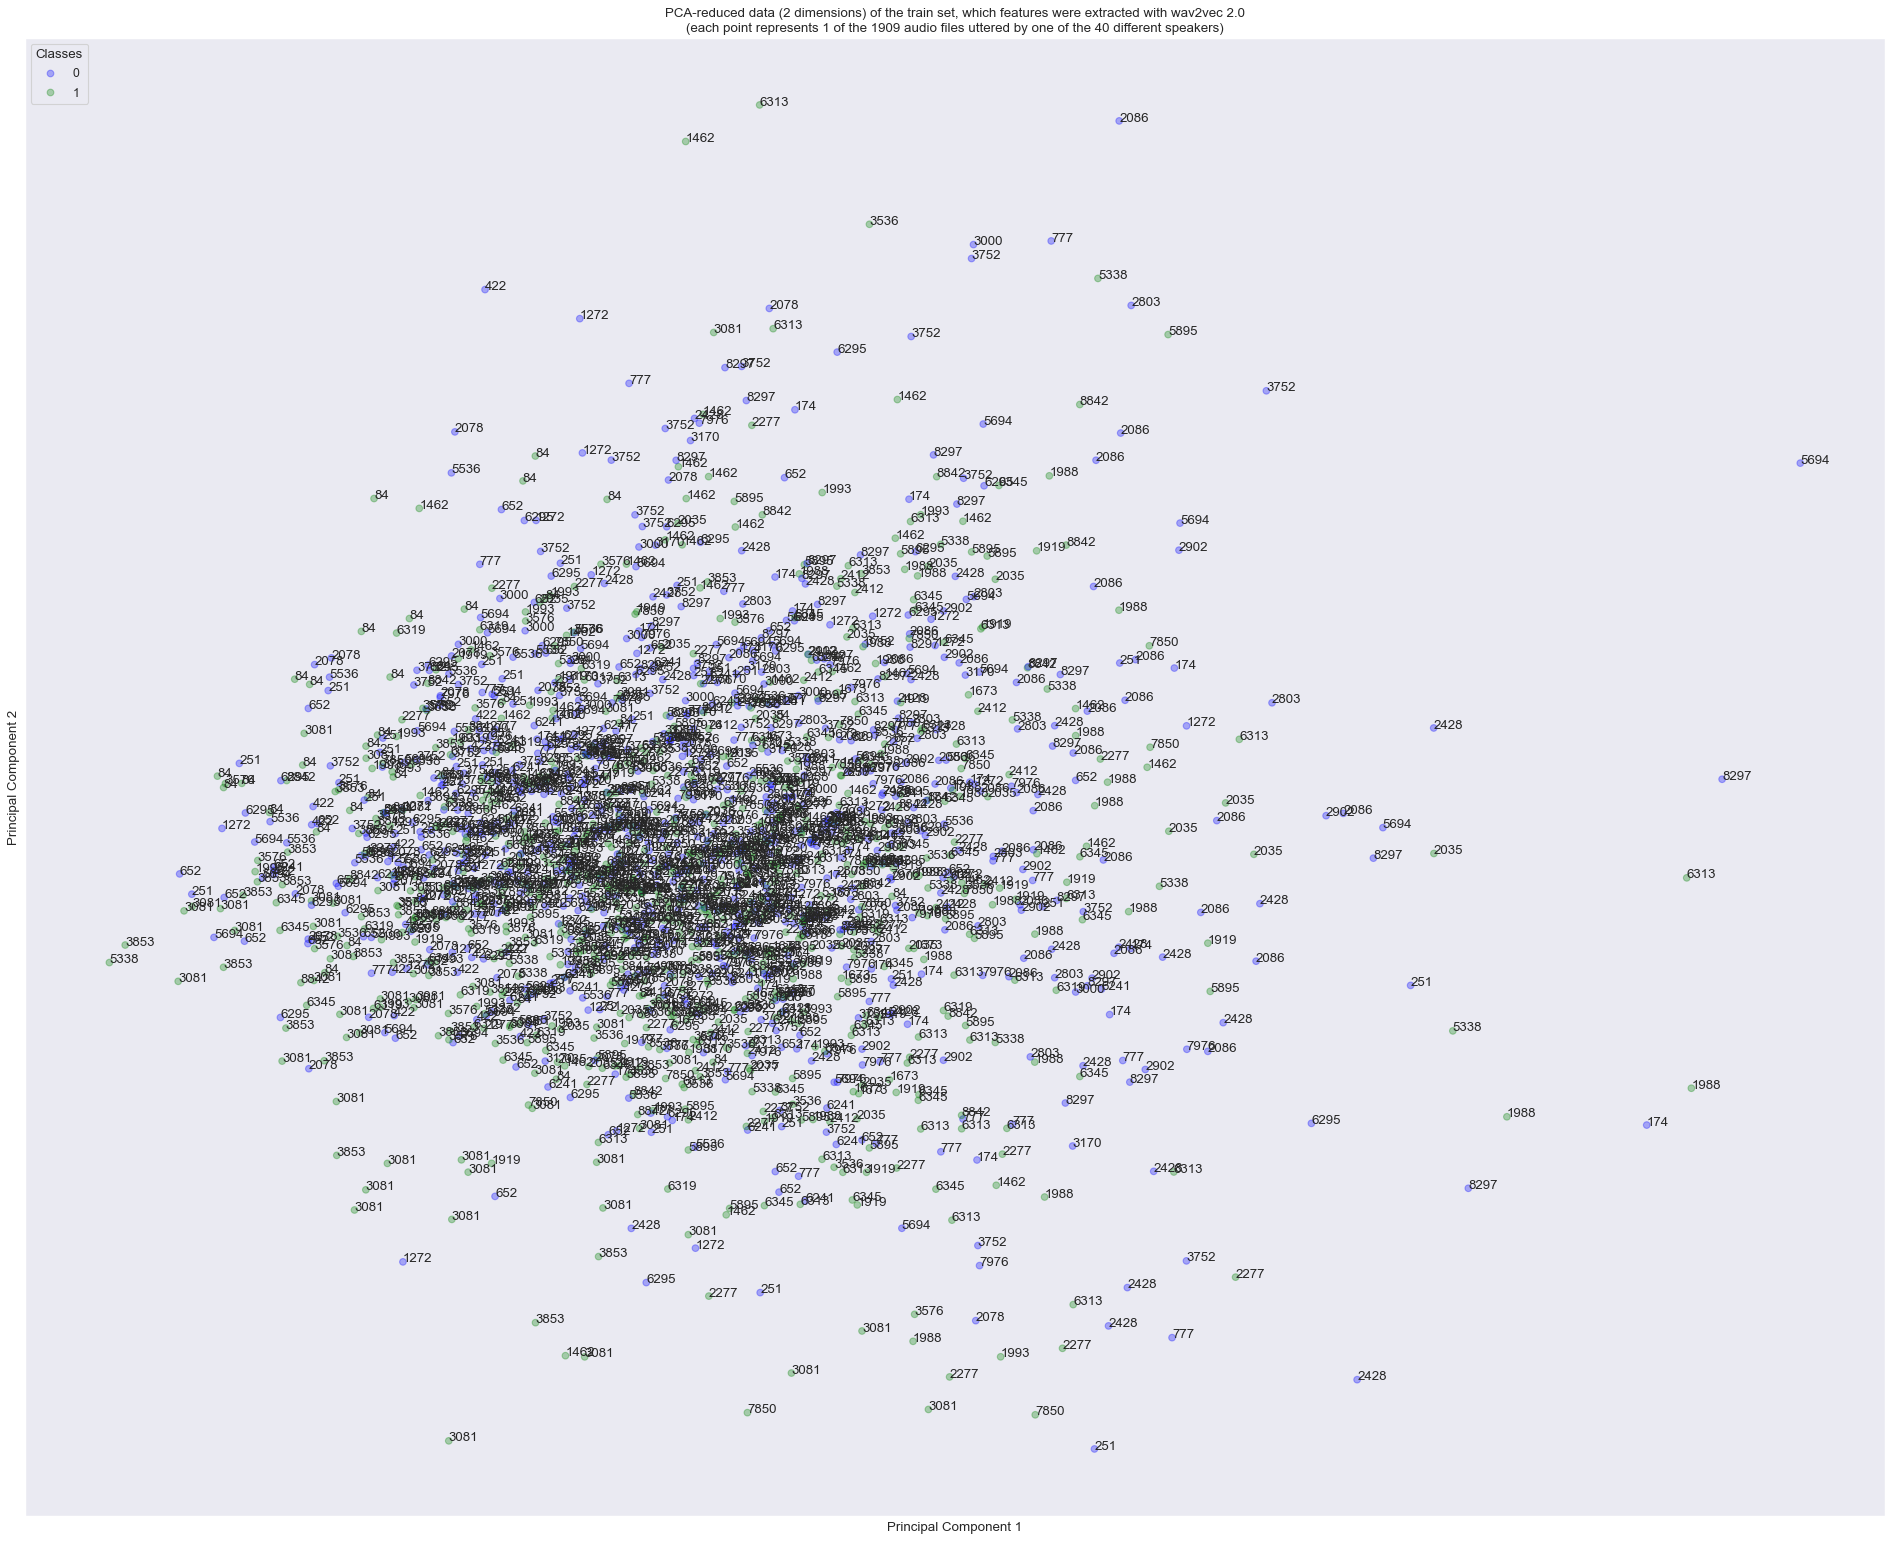

In [90]:
# plot the data in 2 dimentions

figure(figsize=(30, 24), dpi=80)

colors = ['blue','green']
scatter = plt.scatter(reduced_X_train[:, 0], reduced_X_train[:, 1], c=y_train_gender.ravel(), alpha=0.3, cmap=matplotlib.colors.ListedColormap(colors))

# annotate each point with its corresponding speaker number
for i, l in enumerate(y_train_speaker.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
plt.legend(*scatter.legend_elements(),loc="upper left", title="Classes")

plt.title(
    f"PCA-reduced data (2 dimensions) of the train set, which features were extracted with wav2vec 2.0\n"
    f"(each point represents 1 of the {len(y_train_speaker)} audio files uttered by one of the {len(set(y_train_speaker.ravel()))} different speakers)"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()

**Obervation:** It is a bit hard to see in the middle, but we can detect a few clusters with the same speakers on the sides, for example:
- speaker 3081 in the lower left quadrant
- speaker 84 in the upper left quadrant
- speaker 2086 in the upper right quadrant

In [91]:
# speakers of entire dataset
y_speaker = wav2vec_dataset[:, [-2]]
n_speakers = len(set(y_speaker.ravel()))
print(f"Number of speakers in whole dataset: {n_speakers}")

Number of speakers in whole dataset: 40


In [92]:
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,909 samples, 2 dimensions
• Reduced test set:  794 samples, 2 dimensions


In [93]:
# run K-means algorithm on reduced train set with 2 clusters (for male and female)
kmeans = KMeans(init="k-means++", n_clusters=40, n_init=2)
kmeans.fit(reduced_X_train)
kmeans.labels_

array([38, 32, 13, ..., 19, 34, 21], dtype=int32)

In [94]:
# train_acc = (kmeans.predict(reduced_X_train) == y_train_no_outliers.ravel()).sum() / len(y_train_no_outliers)
# print(f"• Mean testing accuracy:  {train_acc:>7.2%}")

# test_acc = (kmeans.predict(reduced_X_test) == y_test.ravel()).sum() / len(y_test)
# print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

#### K-means clustering on PCA-reduced data

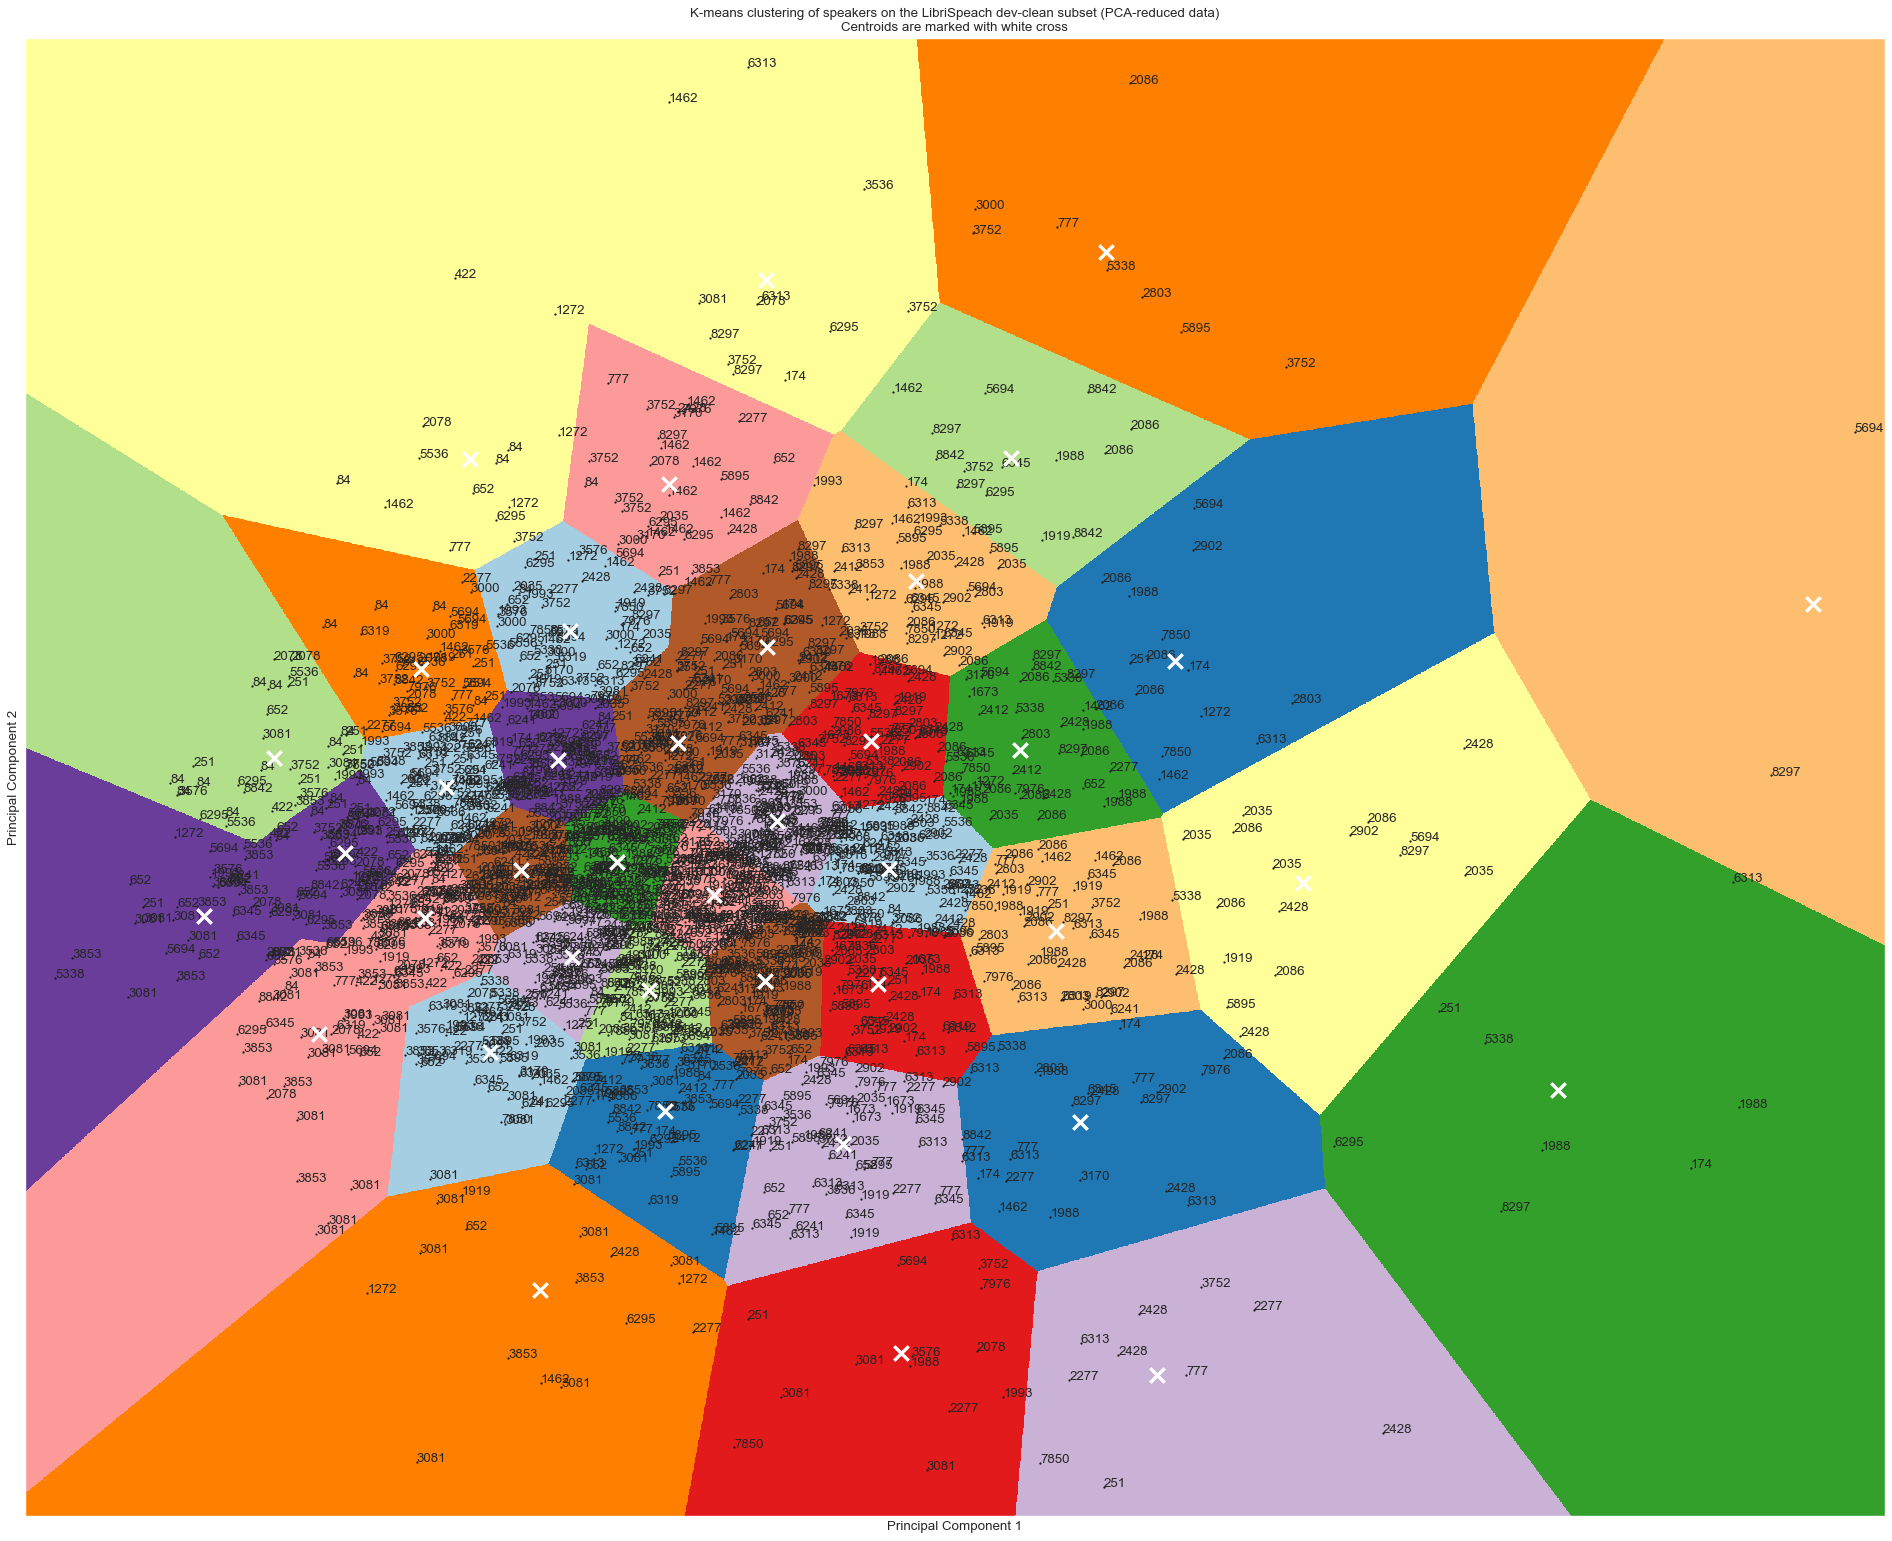

In [95]:
figure(figsize=(30, 24), dpi=80)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_X_train[:, 0].min() - 1, reduced_X_train[:, 0].max() + 1
y_min, y_max = reduced_X_train[:, 1].min() - 1, reduced_X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired, aspect="auto", origin="lower")
plt.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], "k.", markersize=2)

# annotate each point with its corresponding speaker number
for i, l in enumerate(y_train_speaker.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3, color="w", zorder=10)

plt.title(
    f"K-means clustering of speakers on the LibriSpeach dev-clean subset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()